In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from ast import literal_eval
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
# from surprise import Reader, Dataset, SVD, evaluate

import warnings; warnings.simplefilter('ignore')

**Recommender System (Weightage based)**<br>
The basic idea behind this recommender is that movies are recommended based on weighted ratings. This model does not give personalized recommendations based on the user.

In [2]:
md = pd. read_csv(r'D:\MACHINE LEARNING\Mentorship program\Movie Recommender Systems\movies_metadata.csv')

In [3]:
# md['genres'][0]

In [4]:
md['genres'] = md['genres'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [5]:
md.head(2)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[Adventure, Fantasy, Family]",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0


IMDB's weighted rating formula is used to sort the top movies, is represented as follows:<br>

Weighted Rating (WR) =  ((v/v+m).R)+((m/v+m).C)
 
where,

v is the number of votes for the movie
m is the minimum votes required to be listed in the chart
R is the average rating of the movie
C is the mean vote across the whole report
The next step is to determine an appropriate value for m, the minimum votes required to be listed in the chart. We will use 95th percentile as our cutoff. In other words, for a movie to feature in the charts, it must have more votes than at least 95% of the movies in the list.

In [6]:
vote_counts = md[md['vote_count'].notnull()]['vote_count'].astype('int')
vote_averages = md[md['vote_average'].notnull()]['vote_average'].astype('int')
C = vote_averages.mean()
C

5.244896612406511

In [7]:
m = vote_counts.quantile(0.95)
m

434.0

In [8]:
md['year'] = pd.to_datetime(md['release_date'], errors='coerce').apply(lambda x: str(x).split('-')[0] if x != np.nan else np.nan)

In [9]:
md.head(2)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,year
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,1995
1,False,NaN,65000000,"[Adventure, Fantasy, Family]",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,1995


In [10]:
qualified = md[(md['vote_count'] >= m) & (md['vote_count'].notnull()) & (md['vote_average'].notnull())][['title', 'year', 'vote_count', 'vote_average', 'popularity', 'genres']]
qualified['vote_count'] = qualified['vote_count'].astype('int')
qualified['vote_average'] = qualified['vote_average'].astype('int')
qualified.shape

(2274, 6)

In [11]:
qualified

,title,year,vote_count,vote_average,popularity,genres
0,Toy Story,1995,5415,7,21.946943,"[Animation, Comedy, Family]"
1,Jumanji,1995,2413,6,17.015539,"[Adventure, Fantasy, Family]"
5,Heat,1995,1886,7,17.924927,"[Action, Crime, Drama, Thriller]"
9,GoldenEye,1995,1194,6,14.686036,"[Adventure, Action, Thriller]"
15,Casino,1995,1343,7,10.137389,"[Drama, Crime]"
...,...,...,...,...,...,...
44624,What Happened to Monday,2017,598,7,60.581223,"[Science Fiction, Thriller]"
44632,Atomic Blonde,2017,748,6,14.455104,"[Action, Thriller]"
44678,Dunkirk,2017,2712,7,30.938854,"[Action, Drama, History, Thriller, War]"
44842,Transformers: The Last Knight,2017,1440,6,39.186819,"[Action, Science Fiction, Thriller, Adventure]"


In [12]:
def weighted_rating(x):
    v = x['vote_count']
    R = x['vote_average']
    return (v/(v+m) * R) + (m/(m+v) * C)

In [13]:
qualified['wr'] = qualified.apply(weighted_rating, axis=1)

In [14]:
qualified = qualified.sort_values('wr', ascending=False).head(250)

In [15]:
qualified.head(15)

,title,year,vote_count,vote_average,popularity,genres,wr
15480,Inception,2010,14075,8,29.108149,"[Action, Thriller, Science Fiction, Mystery, A...",7.917588
12481,The Dark Knight,2008,12269,8,123.167259,"[Drama, Action, Crime, Thriller]",7.905871
22879,Interstellar,2014,11187,8,32.213481,"[Adventure, Drama, Science Fiction]",7.897107
2843,Fight Club,1999,9678,8,63.869599,[Drama],7.881753
4863,The Lord of the Rings: The Fellowship of the Ring,2001,8892,8,32.070725,"[Adventure, Fantasy, Action]",7.871787
292,Pulp Fiction,1994,8670,8,140.950236,"[Thriller, Crime]",7.868660
314,The Shawshank Redemption,1994,8358,8,51.645403,"[Drama, Crime]",7.864000
7000,The Lord of the Rings: The Return of the King,2003,8226,8,29.324358,"[Adventure, Fantasy, Action]",7.861927
351,Forrest Gump,1994,8147,8,48.307194,"[Comedy, Drama, Romance]",7.860656
5814,The Lord of the Rings: The Two Towers,2002,7641,8,29.423537,"[Adventure, Fantasy, Action]",7.851924


In [16]:
s = md.apply(lambda x: pd.Series(x['genres']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'genre'
gen_md = md.drop('genres', axis=1).join(s)

In [17]:
s

0        Animation
0           Comedy
0           Family
1        Adventure
1          Fantasy
           ...    
45461       Family
45462        Drama
45463       Action
45463        Drama
45463     Thriller
Name: genre, Length: 91106, dtype: object

In [18]:
def build_chart(genre, percentile=0.85):
    df = gen_md[gen_md['genre'] == genre]
    vote_counts = df[df['vote_count'].notnull()]['vote_count'].astype('int')
    vote_averages = df[df['vote_average'].notnull()]['vote_average'].astype('int')
    C = vote_averages.mean()
    m = vote_counts.quantile(percentile)
    
    qualified = df[(df['vote_count'] >= m) & (df['vote_count'].notnull()) & (df['vote_average'].notnull())][['title', 'year', 'vote_count', 'vote_average', 'popularity']]
    qualified['vote_count'] = qualified['vote_count'].astype('int')
    qualified['vote_average'] = qualified['vote_average'].astype('int')
    
    qualified['wr'] = qualified.apply(lambda x: (x['vote_count']/(x['vote_count']+m) * x['vote_average']) + (m/(m+x['vote_count']) * C), axis=1)
    qualified = qualified.sort_values('wr', ascending=False).head(250)
    
    return qualified

In [19]:
build_chart('Romance').head(15)

,title,year,vote_count,vote_average,popularity,wr
10309,Dilwale Dulhania Le Jayenge,1995,661,9,34.457024,8.565285
351,Forrest Gump,1994,8147,8,48.307194,7.971357
876,Vertigo,1958,1162,8,18.20822,7.811667
40251,Your Name.,2016,1030,8,34.461252,7.789489
883,Some Like It Hot,1959,835,8,11.845107,7.745154
1132,Cinema Paradiso,1988,834,8,14.177005,7.744878
19901,Paperman,2012,734,8,7.198633,7.713951
37863,Sing Street,2016,669,8,10.672862,7.689483
882,The Apartment,1960,498,8,11.994281,7.599317
38718,The Handmaiden,2016,453,8,16.727405,7.566166


The top romance movie according to our metrics is Bollywood's Dilwale Dulhania Le Jayenge. This Shahrukh Khan starrer also happens to be one of my personal favorites.

**Content Based Recommender**<br>
Creating a content-based recommendation system for movies in Python involves several steps, such as data preprocessing, feature extraction, and recommendation generation.<br>
To enhance the personalization of our recommendations, I plan to develop a recommendation engine that calculates the similarities between movies by assessing specific criteria. This engine will then propose movies that closely resemble a user's preferred movie. <br>I'll be using Python and libraries like Pandas, Scikit-learn, and TfidfVectorizer for this content-based movie recommendation system.

In [20]:
md['title'].isnull().sum()

6

In [21]:
md['overview'].isnull().sum()

954

In [22]:
md['tagline'].isnull().sum()

25054

In [23]:
md['tagline'] = md['tagline'].fillna('')

In [24]:
md['overview'] = md['overview'].fillna('')

In [25]:
md['description'] = md['overview'] + md['tagline']

In [26]:
md['description'].isnull().sum()

0

In [27]:
md=md.iloc[:10000]

In [28]:
# md.shape

In [29]:
md.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,year,description
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,,Toy Story,False,7.7,5415.0,1995,"Led by Woody, Andy's toys live happily in his ..."
1,False,NaN,65000000,"[Adventure, Fantasy, Family]",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,1995,When siblings Judy and Peter discover an encha...
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[Romance, Comedy]",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,1995,A family wedding reignites the ancient feud be...
3,False,NaN,16000000,"[Comedy, Drama, Romance]",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,1995,"Cheated on, mistreated and stepped on, the wom..."
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,[Comedy],NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,1995,Just when George Banks has recovered from his ...


In [30]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download NLTK data (if not already downloaded)
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

# Text cleaning, tokenization, and lemmatization function
def clean_text(text):
    # Lowercase the text
    text = text.lower()
    # Remove HTML tags (if any)
    text = re.sub(r'<.*?>', '', text)
    # Remove non-alphanumeric characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Tokenization
    words = nltk.word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    # Join the cleaned words back into a sentence
    text = ' '.join(words)
    return text

# Apply the text cleaning function to the 'description' column
md['description'] = md['description'].apply(clean_text)

[nltk_data] Error loading punkt: <urlopen error [WinError 10054] An
[nltk_data]     existing connection was forcibly closed by the remote
[nltk_data]     host>
[nltk_data] Error loading wordnet: <urlopen error [WinError 10054] An
[nltk_data]     existing connection was forcibly closed by the remote
[nltk_data]     host>
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Priyambada\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [31]:
# md['description'][0]

In [32]:
# Create a TF-IDF vectorizer to convert movie descriptions into numerical vectors
tfidf_vectorizer = TfidfVectorizer(stop_words='english')

# Fit and transform the description column to create TF-IDF features
tfidf_matrix = tfidf_vectorizer.fit_transform(md['description'])

In [33]:
tfidf_matrix.shape

(10000, 39294)

**Cosine Similarity**<br>
I will be using the Cosine Similarity to calculate a numeric quantity that denotes the similarity between two movies.<br> 
Since we have used the TF-IDF Vectorizer, calculating the Dot Product will directly give us the Cosine Similarity Score. Therefore, we will use sklearn's linear_kernel instead of cosine_similarities since it is much faster.

In [34]:
# Compute the cosine similarity between movies based on TF-IDF vectors
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [35]:
cosine_sim[0]

array([1.        , 0.01527143, 0.        , ..., 0.        , 0.        ,
       0.        ])

In [36]:
# Function to get movie recommendations based on movie title
def get_recommendations(title, cosine_sim=cosine_sim):
    # Get the index of the movie with the given title
    idx = md[md['title'] == title].index[0]

    # Get the pairwise similarity scores for the movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on similarity scores in descending order
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the top 10 most similar movies (excluding the input movie itself)
    sim_scores = sim_scores[1:11]
    
    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 recommended movies
    return md['title'].iloc[movie_indices]

In [37]:
# Get recommendations for a movie title
movie_title = 'Father of the Bride Part II'
recommendations = get_recommendations(movie_title)
print(f"Recommendations for {movie_title}:")
print(recommendations)

Recommendations for Father of the Bride Part II:
6793      Father of the Bride
6306          North to Alaska
5005                  Wendigo
6571                    Kuffs
926     It's a Wonderful Life
6492             Code Unknown
5571           All Night Long
7097       The Out of Towners
1083           The Eighth Day
1516     George of the Jungle
Name: title, dtype: object


**Collaborative Filtering**<br>
Creating a collaborative recommendation system in Python typically involves using user-item interaction data (e.g., user ratings) to make recommendations.

In [38]:
ratings_df = pd.read_csv(r'D:\MACHINE LEARNING\Mentorship program\Movie Recommender Systems\ratings.csv') 

In [39]:
ratings_df 

,userId,movieId,rating,timestamp
0,1,110,1.0,1425941529
1,1,147,4.5,1425942435
2,1,858,5.0,1425941523
3,1,1221,5.0,1425941546
4,1,1246,5.0,1425941556
...,...,...,...,...
26024284,270896,58559,5.0,1257031564
26024285,270896,60069,5.0,1257032032
26024286,270896,63082,4.5,1257031764
26024287,270896,64957,4.5,1257033990


In [40]:
ratings_df =ratings_df.iloc[:10000]

In [41]:
ratings_df['rating'].describe()

count    10000.000000
mean         3.660050
std          1.022235
min          0.500000
25%          3.000000
50%          4.000000
75%          4.500000
max          5.000000
Name: rating, dtype: float64

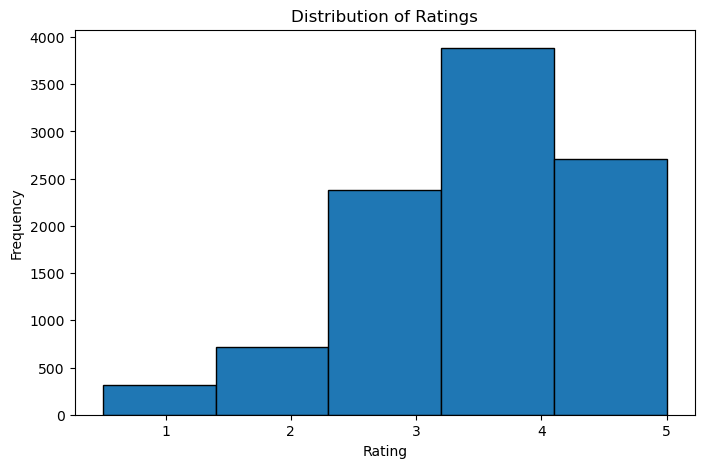

In [42]:
# EDA: Plot a histogram of ratings
plt.figure(figsize=(8, 5))
plt.hist(ratings_df ['rating'], bins=5, edgecolor='black')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

In [43]:
# Pivot the ratings data to create a user-item matrix
user_item_matrix = ratings_df.pivot(index='userId', columns='movieId', values='rating')    

In [44]:
user_item_matrix

movieId,1,2,3,5,6,7,8,10,11,13,...,164909,166461,166528,166635,168252,168434,168612,171763,172547,174585
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
117,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
118,3.0,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
user_item_matrix.fillna(0, inplace=True)

In [46]:
user_item_matrix

movieId,1,2,3,5,6,7,8,10,11,13,...,164909,166461,166528,166635,168252,168434,168612,171763,172547,174585
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
117,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
118,3.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [47]:
from sklearn.metrics.pairwise import cosine_similarity
user_similarity = cosine_similarity(user_item_matrix)

In [48]:
user_similarity

array([[1.        , 0.        , 0.13953492, ..., 0.        , 0.        ,
        0.03462418],
       [0.        , 1.        , 0.        , ..., 0.2391363 , 0.06601658,
        0.16221772],
       [0.13953492, 0.        , 1.        , ..., 0.        , 0.09034618,
        0.13463291],
       ...,
       [0.        , 0.2391363 , 0.        , ..., 1.        , 0.03932013,
        0.12217565],
       [0.        , 0.06601658, 0.09034618, ..., 0.03932013, 1.        ,
        0.28055143],
       [0.03462418, 0.16221772, 0.13463291, ..., 0.12217565, 0.28055143,
        1.        ]])

In [49]:
cosine_sim_df = pd.DataFrame(user_similarity, index=user_item_matrix.index, columns=user_item_matrix.index)

In [50]:
cosine_sim_df 

userId,1,2,3,4,5,6,7,8,9,10,...,111,112,113,114,115,116,117,118,119,120
userId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.000000,0.139535,0.090536,0.048171,0.000000,0.183766,0.027008,0.091693,0.000000,...,0.156838,0.000000,0.000000,0.000000,0.031898,0.000000,0.028199,0.000000,0.000000,0.034624
2,0.000000,1.000000,0.000000,0.051512,0.000000,0.000000,0.000000,0.029026,0.000000,0.000000,...,0.042800,0.084322,0.102534,0.000000,0.095988,0.000000,0.019888,0.239136,0.066017,0.162218
3,0.139535,0.000000,1.000000,0.052872,0.156224,0.000000,0.000000,0.026814,0.000000,0.000000,...,0.054141,0.000000,0.000000,0.045570,0.049261,0.000000,0.012248,0.000000,0.090346,0.134633
4,0.090536,0.051512,0.052872,1.000000,0.031152,0.000000,0.024531,0.055101,0.184090,0.000000,...,0.027842,0.000000,0.000000,0.000000,0.100562,0.136401,0.011397,0.020454,0.000000,0.007997
5,0.048171,0.000000,0.156224,0.031152,1.000000,0.069383,0.000000,0.007899,0.046623,0.057455,...,0.035677,0.000000,0.000000,0.044748,0.131697,0.000000,0.050515,0.000000,0.031938,0.108859
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,0.000000,0.000000,0.000000,0.136401,0.000000,0.000000,0.000000,0.040352,0.042978,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.003695
117,0.028199,0.019888,0.012248,0.011397,0.050515,0.031731,0.056827,0.020471,0.103807,0.031532,...,0.076399,0.064263,0.034030,0.053209,0.164263,0.000000,1.000000,0.023691,0.032865,0.094361
118,0.000000,0.239136,0.000000,0.020454,0.000000,0.000000,0.000000,0.055323,0.021751,0.000000,...,0.038583,0.116071,0.195424,0.000000,0.071464,0.000000,0.023691,1.000000,0.039320,0.122176


In [51]:
def get_movie_recommendations(user_id, num_recommendations=20):
    user_ratings = user_item_matrix.loc[user_id]
    
    # Calculate the weighted average of ratings for similar users
    weighted_ratings = np.dot(user_similarity[user_id - 1], user_item_matrix.values)
    
    # Filter out movies the user has already rated
    unrated_movies = (user_ratings == 0)
    
    # Sort by the weighted ratings and get the top recommendations
    recommendations = pd.Series(weighted_ratings, index=user_item_matrix.columns)
    recommendations = recommendations[unrated_movies].sort_values(ascending=False)
    
    return recommendations.head(num_recommendations)

In [52]:
# Get movie recommendations for a specific user (e.g., user 1)
user_id = 3
recommendations = get_movie_recommendations(user_id)
print("Movie Recommendations for User", user_id)
print(recommendations)

Movie Recommendations for User 3
movieId
593     15.646040
296     15.508267
318     14.490188
50      13.025380
2571    12.793509
1198    12.237779
260     11.473619
356     11.401116
1196    11.136274
1       10.827013
457     10.679824
2959    10.179664
2762    10.135203
110      9.688862
589      9.445235
2028     9.370754
1210     9.345231
47       8.907657
541      8.586716
150      8.407309
dtype: float64


In [53]:
recom_df = pd.DataFrame(recommendations)

In [66]:
# recom_df 

In [55]:
recom_df = recom_df.reset_index()
recom_df['weighted_ratings'] = recom_df[0]
recom_df = recom_df.drop(0, axis = 1)

In [56]:
movies_df = pd.read_csv(r'D:\MACHINE LEARNING\Mentorship program\Movie Recommender Systems\movies_metadata.csv') 

In [57]:
movies_df = movies_df[['id','title']]

In [69]:
movies_df.head()

,title,movieId
0,Toy Story,862
1,Jumanji,8844
2,Grumpier Old Men,15602
3,Waiting to Exhale,31357
4,Father of the Bride Part II,11862


In [58]:
movies_df['movieId'] = movies_df.id

In [59]:
movies_df = movies_df.drop('id', axis =1)

In [60]:
movies_df = movies_df.dropna()

In [61]:
movies_df['movieId'] = movies_df['movieId'].astype(int)

In [62]:
merged_df = recom_df.merge(movies_df, on='movieId', how='left')

In [63]:
merged_df

,movieId,weighted_ratings,title
0,593,15.646040,Solaris
1,296,15.508267,Terminator 3: Rise of the Machines
2,318,14.490188,The Million Dollar Hotel
3,50,13.025380,NaN
4,2571,12.793509,NaN
5,1198,12.237779,NaN
6,260,11.473619,The 39 Steps
7,356,11.401116,NaN
8,1196,11.136274,NaN
9,1,10.827013,NaN


In [64]:
merged_df = merged_df.dropna().head(10).reset_index(drop = True)

In [65]:
merged_df

,movieId,weighted_ratings,title
0,593,15.646040,Solaris
1,296,15.508267,Terminator 3: Rise of the Machines
2,318,14.490188,The Million Dollar Hotel
3,260,11.473619,The 39 Steps
4,457,10.679824,Sissi
5,2959,10.179664,License to Wed
6,2762,10.135203,Young and Innocent
7,110,9.688862,Three Colors: Red
8,2028,9.370754,Say Anything...
9,541,8.586716,The Man with the Golden Arm


In conclusion, this code snippet provides a basic example of how to perform exploratory data analysis (EDA) on a movie ratings dataset and implement a movie recommendation system using collaborative filtering based on user similarity. The recommendations aim to suggest movies that a specific user might enjoy based on their own ratings and the preferences of similar users. This code can serve as a starting point for conducting more in-depth analysis on larger datasets.